In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [148]:
df = pd.read_csv("air-quality-in-nairobi.csv") 

In [149]:
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
1,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
2,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
3,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
4,79;SDS011;30;-1.290;36.777;2019-09-01T00:00:06...


In [181]:
# Load with semicolon as separator
df = pd.read_csv("air-quality-in-nairobi.csv", sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P2,7.20
1,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P1,10.03
2,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,humidity,99.90
3,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,temperature,16.10
4,79,SDS011,30,-1.290,36.777,2019-09-01T00:00:06.128592+00:00,P2,6.93


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719404 entries, 0 to 719403
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    719404 non-null  int64  
 1   sensor_type  719404 non-null  object 
 2   location     719404 non-null  int64  
 3   lat          719404 non-null  float64
 4   lon          719404 non-null  float64
 5   timestamp    719404 non-null  object 
 6   value_type   719404 non-null  object 
 7   value        719404 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 43.9+ MB


In [182]:
# parse timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [183]:
# pivot so each value_type becomes its own column; group by timestamp & location
df_wide = df.pivot_table(
    index=['timestamp','location'],
    columns='value_type',
    values='value',
    aggfunc='mean'
).reset_index()

# Flatten columns
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
df_wide.head()

,timestamp,location,P1,P2,humidity,temperature
0,2019-09-01 00:00:02.236776+00:00,68,10.03,7.20,NaN,NaN
1,2019-09-01 00:00:05.613250+00:00,68,NaN,NaN,99.9,16.1
2,2019-09-01 00:00:06.128592+00:00,30,10.40,6.93,NaN,NaN
3,2019-09-01 00:00:08.844578+00:00,30,NaN,NaN,99.9,17.3
4,2019-09-01 00:00:09.836965+00:00,59,0.10,0.10,NaN,NaN


In [184]:
# Create AQI labels

def pm25_to_aqi(pm):
    if pd.isna(pm):
        return None
    pm = float(pm)
    if pm <= 12.0:
        return "Good"
    elif pm <= 35.4:
        return "Moderate"
    elif pm <= 55.4:
        return "Unhealthy-Sensitive"
    elif pm <= 150.4:
        return "Unhealthy"
    elif pm <= 250.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df_wide['AQI_Category'] = df_wide['P2'].apply(pm25_to_aqi)

def simplify_category(cat):
    if cat in ["Good","Moderate"]:
        return "Healthy"
    else:
        return "Unhealthy"

df_wide['AQI_Binary'] = df_wide['AQI_Category'].apply(simplify_category)
df_wide['AQI_Binary_Num'] = df_wide['AQI_Binary'].map({'Healthy':1, 'Unhealthy':0})

print(df_wide[['P2','AQI_Category','AQI_Binary','AQI_Binary_Num']].head())
print("Class counts:\n", df_wide['AQI_Binary'].value_counts())


     P2 AQI_Category AQI_Binary  AQI_Binary_Num
0  7.20         Good    Healthy               1
1   NaN         None  Unhealthy               0
2  6.93         Good    Healthy               1
3   NaN         None  Unhealthy               0
4  0.10         Good    Healthy               1
Class counts:
 AQI_Binary
Healthy      181366
Unhealthy    178320
Name: count, dtype: int64


In [185]:
df_wide.shape

(359686, 9)

In [186]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   timestamp       359686 non-null  datetime64[ns, UTC]
 1   location        359686 non-null  int64              
 2   P1              186444 non-null  float64            
 3   P2              186444 non-null  float64            
 4   humidity        173257 non-null  float64            
 5   temperature     173257 non-null  float64            
 6   AQI_Category    186444 non-null  object             
 7   AQI_Binary      359686 non-null  object             
 8   AQI_Binary_Num  359686 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(2)
memory usage: 24.7+ MB


In [187]:
df_wide.isnull().sum()

timestamp              0
location               0
P1                173242
P2                173242
humidity          186429
temperature       186429
AQI_Category      173242
AQI_Binary             0
AQI_Binary_Num         0
dtype: int64

In [188]:
# Numerical columns
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df_wide.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['location', 'P1', 'P2', 'humidity', 'temperature', 'AQI_Binary_Num']
Categorical Columns: ['AQI_Category', 'AQI_Binary']


In [160]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df_wide[col].unique())
    print("Unique count:", df_wide[col].nunique())



Column: AQI_Category
['Good' None 'Moderate' 'Unhealthy' 'Unhealthy-Sensitive' 'Hazardous'
 'Very Unhealthy']
Unique count: 6

Column: AQI_Binary
['Healthy' 'Unhealthy']
Unique count: 2


In [189]:
df_wide.describe()

,location,P1,P2,humidity,temperature,AQI_Binary_Num
count,359686.000000,186444.000000,186444.000000,173257.000000,173257.000000,359686.000000
mean,50.218883,21.653899,11.245230,68.480078,22.996220,0.504234
std,18.575967,34.982505,14.313417,21.373744,9.949977,0.499983
min,7.000000,0.000000,0.000000,22.700000,11.800000,0.000000
25%,29.000000,9.020000,4.870000,51.699829,18.800000,0.000000
50%,61.000000,14.850000,7.700000,65.900000,21.700000,1.000000
75%,68.000000,24.370000,12.930000,89.100000,24.800000,1.000000
max,70.000000,1999.900000,999.900000,99.998474,99.998474,1.000000


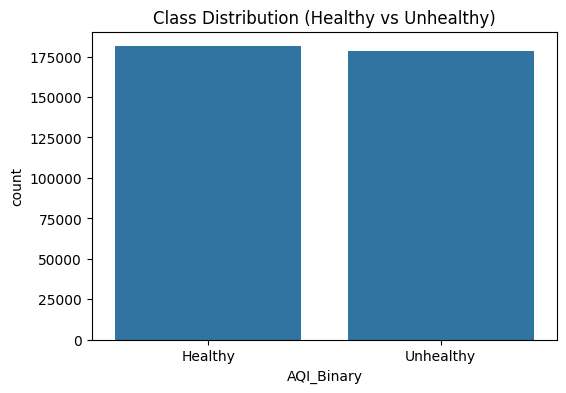

In [130]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_wide, x='AQI_Binary')
plt.title("Class Distribution (Healthy vs Unhealthy)")
plt.show()

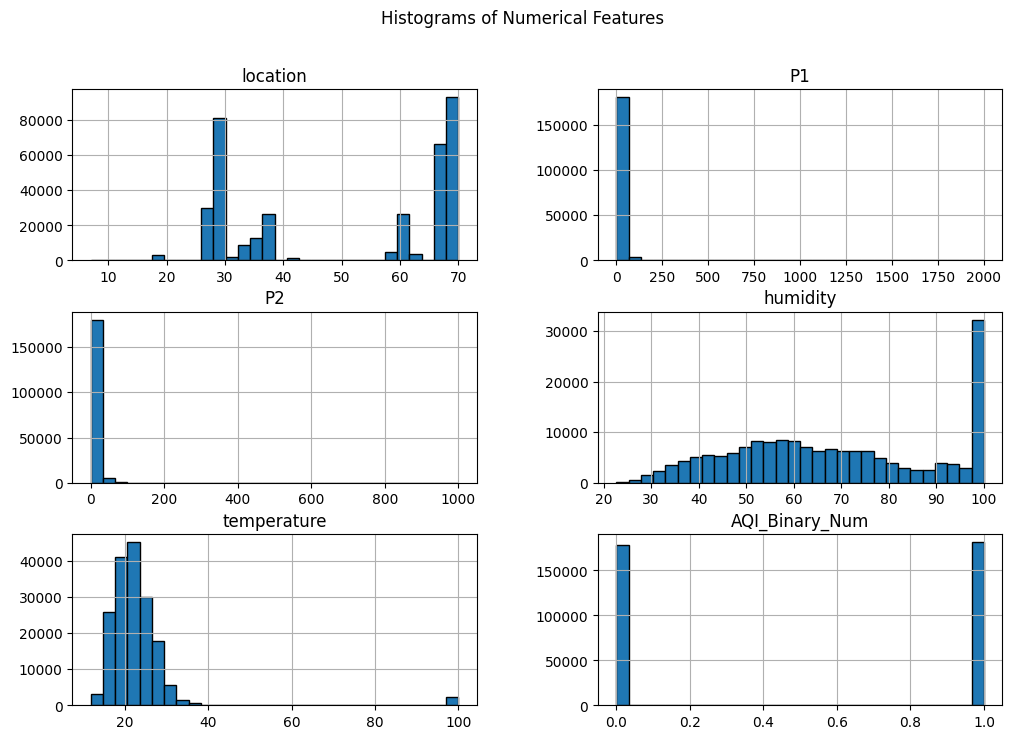

In [107]:
# Numerical columns (excluding timestamp, location, and categorical)
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df_wide[num_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

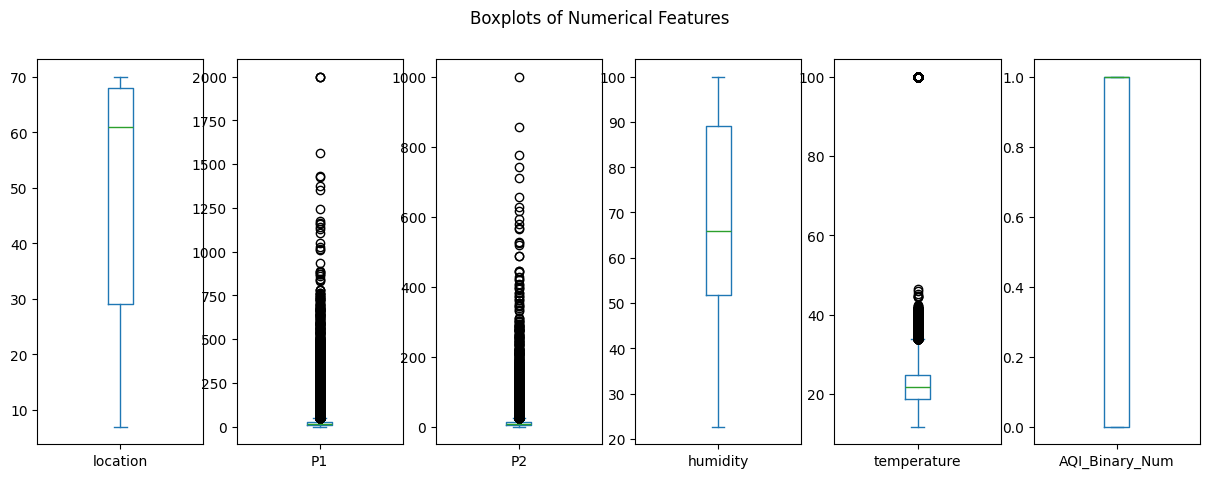

In [108]:
# Boxplots
plt.figure(figsize=(12, 6))
df_wide[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(15, 5), sharey=False)
plt.suptitle("Boxplots of Numerical Features")
plt.show()

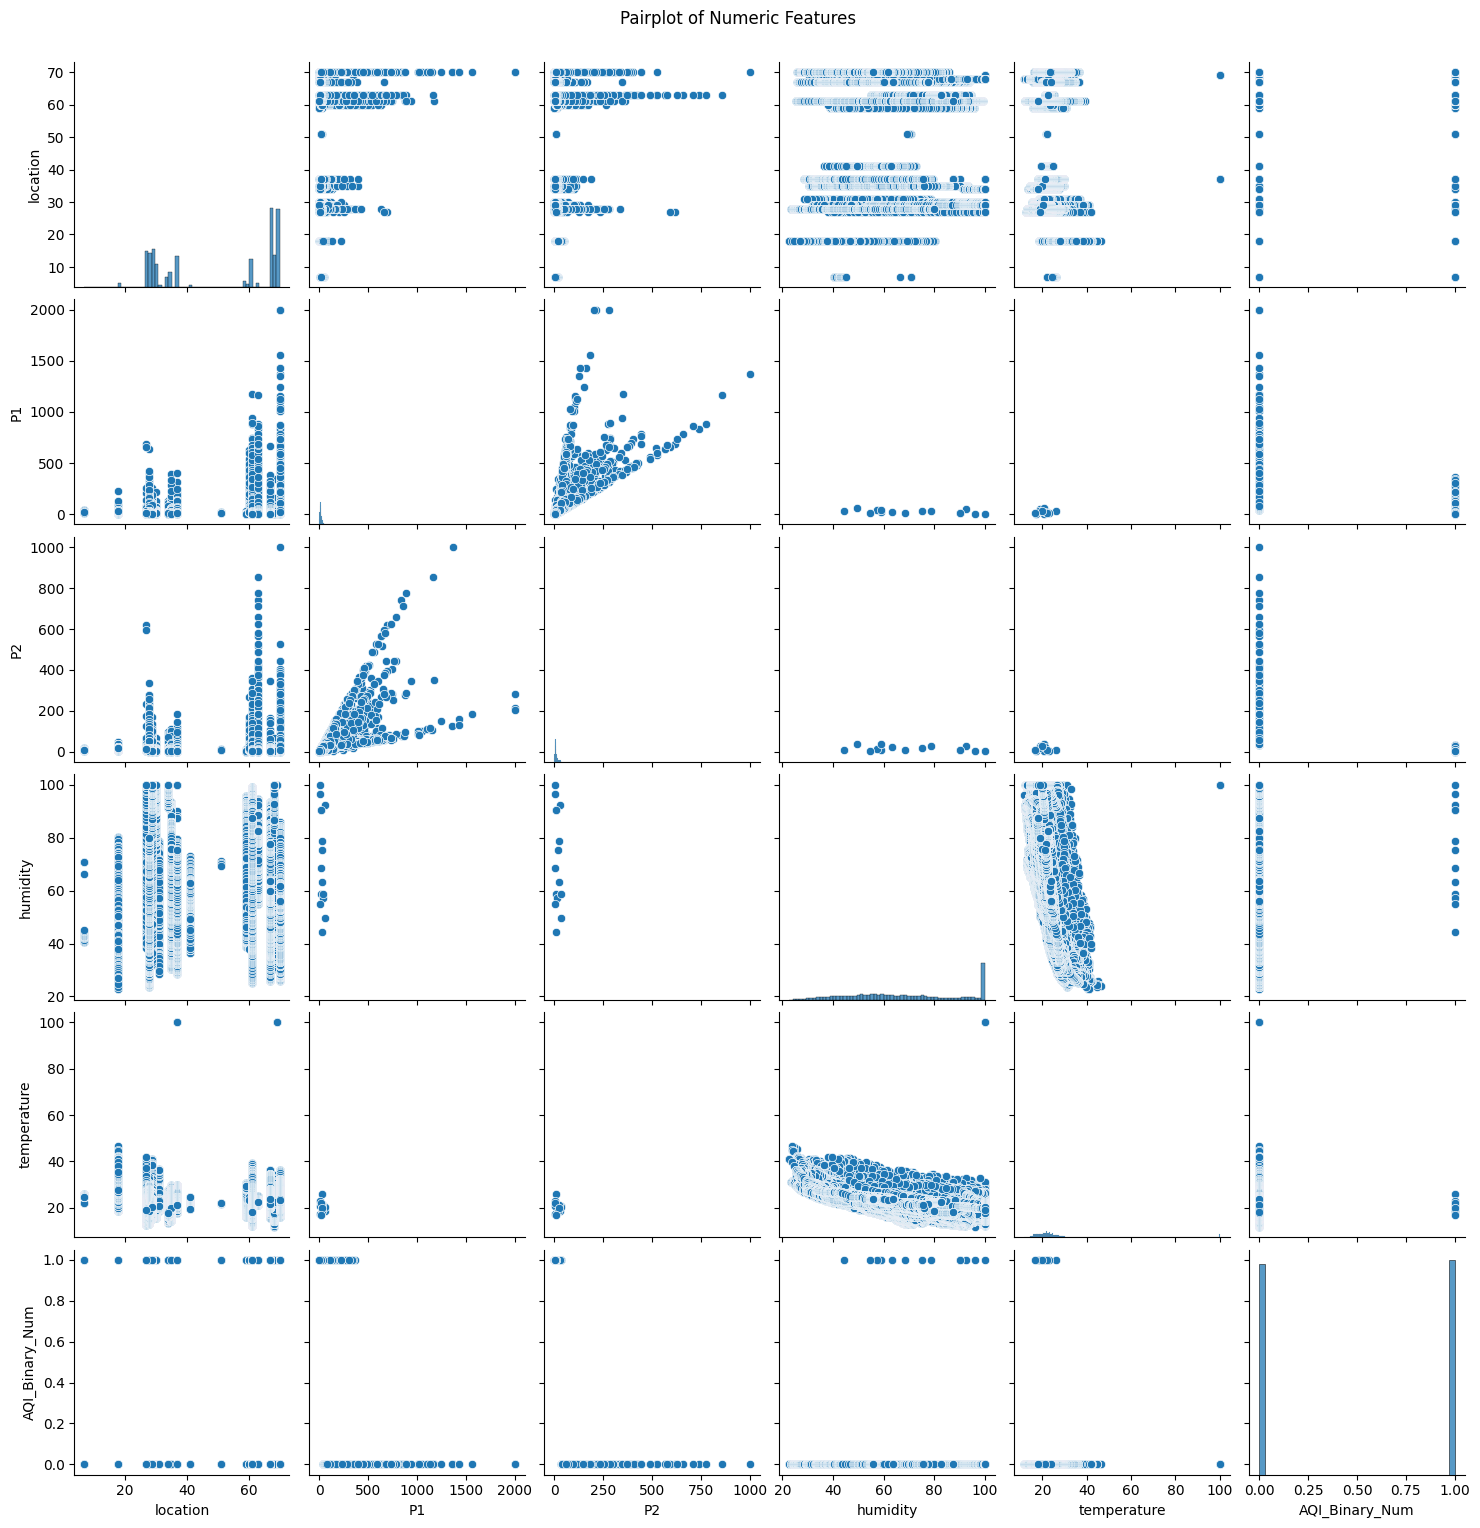

In [115]:
# Pairplot for all numeric columns
sns.pairplot(df_wide[num_cols])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

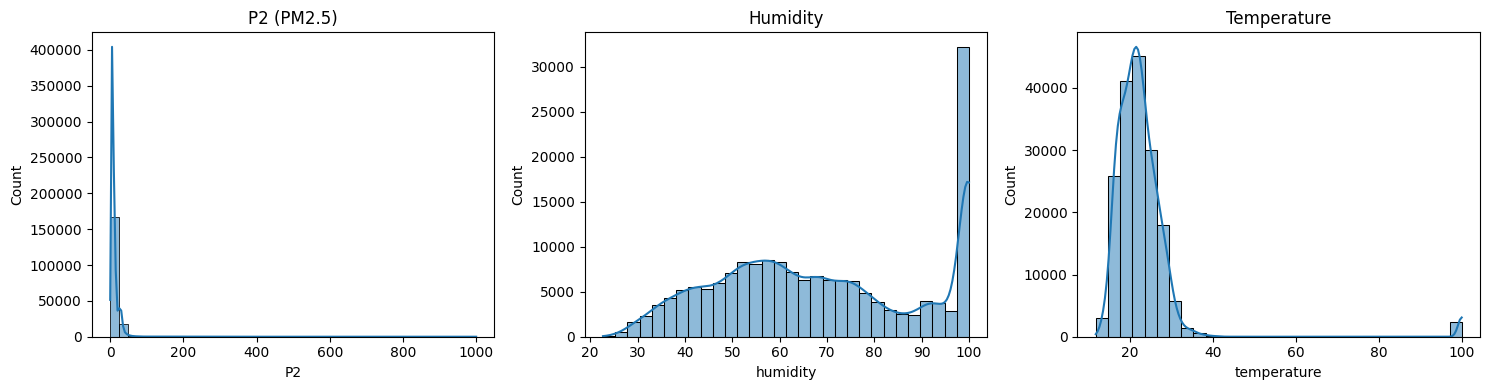

In [14]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df_wide['P2'], bins=40, kde=True, ax=axes[0]).set_title('P2 (PM2.5)')
sns.histplot(df_wide['humidity'], bins=30, kde=True, ax=axes[1]).set_title('Humidity')
sns.histplot(df_wide['temperature'], bins=30, kde=True, ax=axes[2]).set_title('Temperature')
plt.tight_layout()
plt.show()

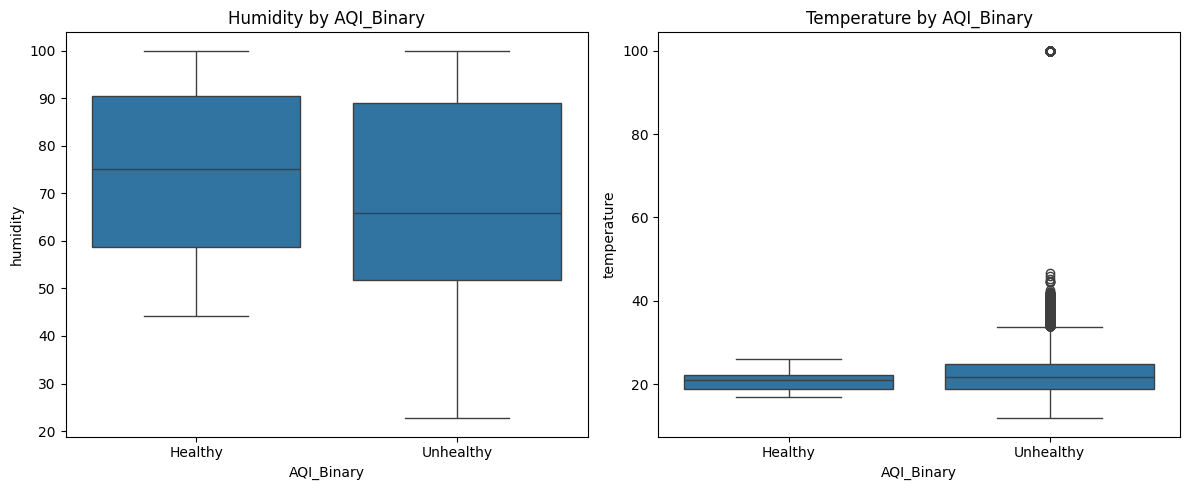

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(data=df_wide, x='AQI_Binary', y='humidity', ax=axes[0])
axes[0].set_title('Humidity by AQI_Binary')
sns.boxplot(data=df_wide, x='AQI_Binary', y='temperature', ax=axes[1])
axes[1].set_title('Temperature by AQI_Binary')
plt.tight_layout()
plt.show()

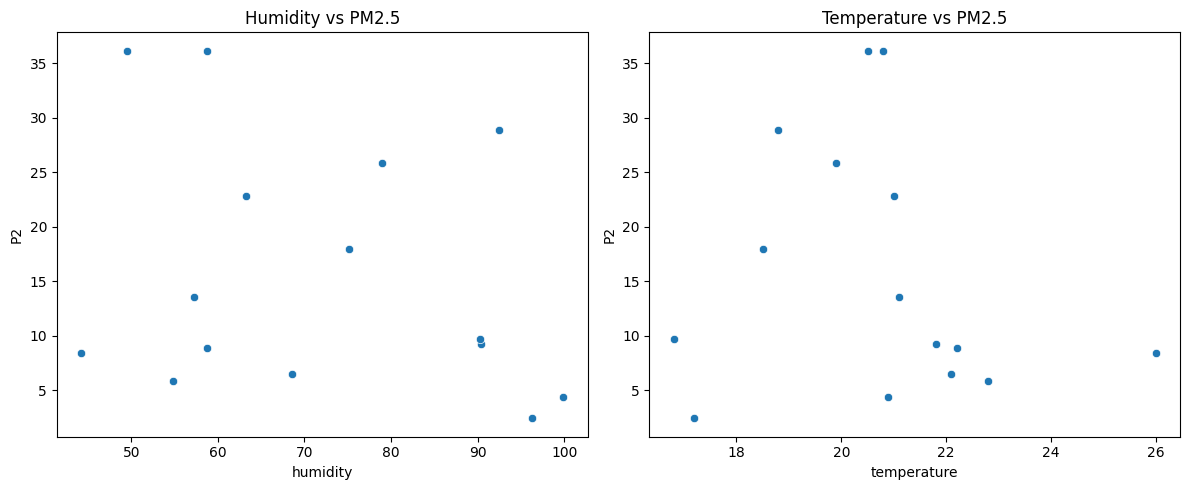

In [25]:
# Example scatter plots between features and P2 (PM2.5)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='humidity', y='P2', data=df_wide)
plt.title("Humidity vs PM2.5")

plt.subplot(1, 2, 2)
sns.scatterplot(x='temperature', y='P2', data=df_wide)
plt.title("Temperature vs PM2.5")

plt.tight_layout()
plt.show()


### Preprocessing

In [190]:
df_wide.columns

Index(['timestamp', 'location', 'P1', 'P2', 'humidity', 'temperature',
       'AQI_Category', 'AQI_Binary', 'AQI_Binary_Num'],
      dtype='object')

In [191]:
# Drop columns not useful for prediction
df_wide.drop(["timestamp", "P1", "AQI_Category", "AQI_Binary"], axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:", df_wide.columns.tolist())
print(df_wide.info())


Remaining columns: ['location', 'P2', 'humidity', 'temperature', 'AQI_Binary_Num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   location        359686 non-null  int64  
 1   P2              186444 non-null  float64
 2   humidity        173257 non-null  float64
 3   temperature     173257 non-null  float64
 4   AQI_Binary_Num  359686 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 13.7 MB
None


In [192]:
df_wide.isnull().sum()

location               0
P2                173242
humidity          186429
temperature       186429
AQI_Binary_Num         0
dtype: int64

In [193]:
# Impute missing humidity and temperature with their median
for col in ['humidity', 'temperature']:
    if df_wide[col].isnull().any():
        median_val = df_wide[col].median()
        df_wide[col] = df_wide[col].fillna(median_val)

print(df_wide[['humidity','temperature']].isnull().sum())


humidity       0
temperature    0
dtype: int64


In [194]:
# Impute 'P2' with median
df_wide['P2'] = df_wide['P2'].fillna(df_wide['P2'].median())

In [195]:
df_wide.isnull().sum()

location          0
P2                0
humidity          0
temperature       0
AQI_Binary_Num    0
dtype: int64

In [196]:
# Check number of duplicates before removal
print("Duplicate rows in original dataset:", df_wide.duplicated().sum())

# Remove duplicate rows
df_wide = df_wide.drop_duplicates()

# Check number of duplicates after removal
print("Duplicate rows after removal:", df_wide.duplicated().sum())

# Optional: reset the index after dropping
df_wide.reset_index(drop=True, inplace=True)


Duplicate rows in original dataset: 249562
Duplicate rows after removal: 0


In [197]:


# Function to cap outliers using IQR
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Replace values outside bounds with the bounds
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping to humidity and temperature
df_capped = df_wide.copy()
for col in ['humidity', 'temperature']:
    df_capped = cap_outliers_iqr(df_capped, col)

print("Outliers capped for humidity and temperature.")
print(df_capped[['humidity','temperature']].describe())


Outliers capped for humidity and temperature.
            humidity    temperature
count  110124.000000  110124.000000
mean       62.427732      22.776369
std        17.051180       3.849898
min        22.700000      13.200000
25%        49.800000      20.400000
50%        64.999390      21.700000
75%        72.500000      25.200000
max        99.998474      32.400000


In [198]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Use sparse_output=False for newer sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit + transform
loc_encoded = encoder.fit_transform(df_wide[['location']])

# Get new column names
loc_cols = encoder.get_feature_names_out(['location'])

# Build encoded DataFrame
loc_df = pd.DataFrame(loc_encoded, columns=loc_cols, index=df_wide.index)

# Drop old location and join encoded
df_encoded = pd.concat([df_wide.drop(columns=['location']), loc_df], axis=1)

print("Final columns after encoding:")
print(df_encoded.columns.tolist())


Final columns after encoding:
['P2', 'humidity', 'temperature', 'AQI_Binary_Num', 'location_7', 'location_18', 'location_27', 'location_28', 'location_29', 'location_30', 'location_31', 'location_34', 'location_35', 'location_37', 'location_41', 'location_51', 'location_59', 'location_60', 'location_61', 'location_63', 'location_67', 'location_68', 'location_69', 'location_70']


### Define features & target

In [171]:
 # Define features (X) and target (y)
X = df_encoded.drop(columns=['AQI_Binary_Num'])
y = df_encoded['AQI_Binary_Num']

### Split the data

In [199]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling

In [200]:
# identify columns
num_standard = ['humidity']         # normal → StandardScaler
num_robust = ['temperature', 'P2']  # skew/outliers → RobustScaler
onehot_cols = [c for c in X.columns if c.startswith('location_')]  # already one-hot

# preprocessing
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_standard),
    ('rob', RobustScaler(), num_robust),
    ('pass', 'passthrough', onehot_cols)
])


In [201]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Training set after SMOTE: {X_train_res.shape}, {y_train_res.shape}")

Training set after SMOTE: (155202, 23), (155202,)


### Training and Evaluation

Model: LogReg
Train Accuracy: 0.89
Test Accuracy : 0.89

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     77601
           1       0.77      0.16      0.26     10498

    accuracy                           0.89     88099
   macro avg       0.84      0.58      0.60     88099
weighted avg       0.88      0.89      0.86     88099

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     19400
           1       0.74      0.15      0.25      2625

    accuracy                           0.89     22025
   macro avg       0.82      0.57      0.60     22025
weighted avg       0.88      0.89      0.86     22025



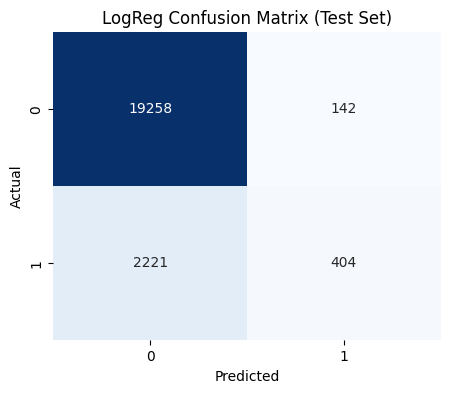


Model: DecisionTree
Train Accuracy: 1.00
Test Accuracy : 1.00

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77601
           1       1.00      1.00      1.00     10498

    accuracy                           1.00     88099
   macro avg       1.00      1.00      1.00     88099
weighted avg       1.00      1.00      1.00     88099

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19400
           1       1.00      1.00      1.00      2625

    accuracy                           1.00     22025
   macro avg       1.00      1.00      1.00     22025
weighted avg       1.00      1.00      1.00     22025



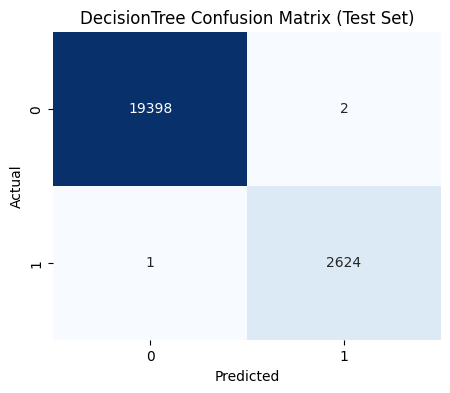


Model: RandomForest
Train Accuracy: 1.00
Test Accuracy : 1.00

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77601
           1       1.00      1.00      1.00     10498

    accuracy                           1.00     88099
   macro avg       1.00      1.00      1.00     88099
weighted avg       1.00      1.00      1.00     88099

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19400
           1       1.00      1.00      1.00      2625

    accuracy                           1.00     22025
   macro avg       1.00      1.00      1.00     22025
weighted avg       1.00      1.00      1.00     22025



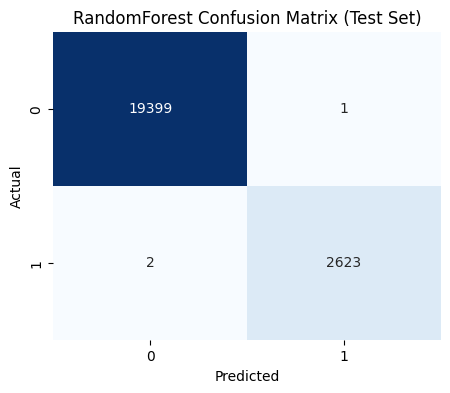


Model: GradientBoost
Train Accuracy: 1.00
Test Accuracy : 1.00

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77601
           1       1.00      1.00      1.00     10498

    accuracy                           1.00     88099
   macro avg       1.00      1.00      1.00     88099
weighted avg       1.00      1.00      1.00     88099

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19400
           1       1.00      1.00      1.00      2625

    accuracy                           1.00     22025
   macro avg       1.00      1.00      1.00     22025
weighted avg       1.00      1.00      1.00     22025



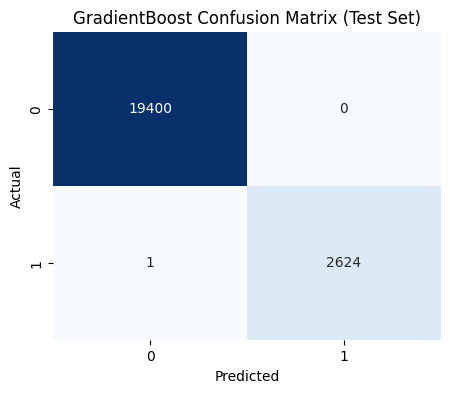


Model: LinearSVM
Train Accuracy: 0.89
Test Accuracy : 0.89

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     77601
           1       0.77      0.16      0.26     10498

    accuracy                           0.89     88099
   macro avg       0.83      0.58      0.60     88099
weighted avg       0.88      0.89      0.86     88099

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     19400
           1       0.74      0.15      0.25      2625

    accuracy                           0.89     22025
   macro avg       0.82      0.57      0.60     22025
weighted avg       0.88      0.89      0.86     22025



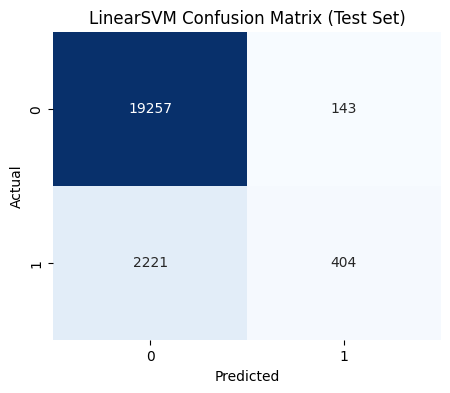

In [205]:
from sklearn.svm import LinearSVC

# Define models (with LinearSVC, without SVM kernel)
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoost': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # scaling, imputation
        ('classifier', model)
    ])
    
    # Fit model
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy : {test_acc:.2f}\n")
    
    # Classification reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")


Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV F1 Score: 0.7206644103619058

Training Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     77601
           1       0.75      0.69      0.72     77601

    accuracy                           0.73    155202
   macro avg       0.73      0.73      0.73    155202
weighted avg       0.73      0.73      0.73    155202



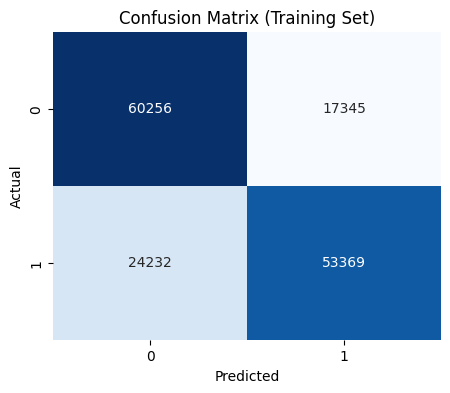


Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     19400
           1       0.30      0.69      0.42      2625

    accuracy                           0.77     22025
   macro avg       0.62      0.73      0.64     22025
weighted avg       0.87      0.77      0.81     22025



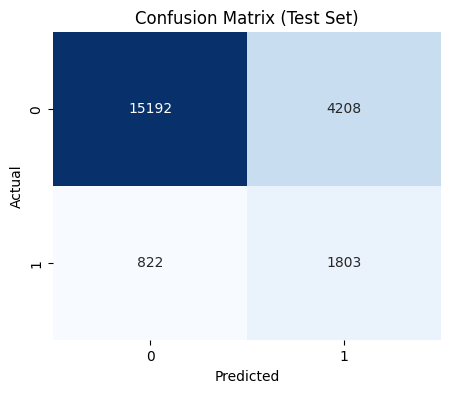

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define pipeline with preprocessor
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # compatible with l1
}

# Grid search with 5-fold cross-validation, scoring F1
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

# Best parameters and score
print("Best Hyperparameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

# Evaluate on training data
y_train_pred = grid.predict(X_train_res)
print("\nTraining Classification Report:")
print(classification_report(y_train_res, y_train_pred))
cm_train = confusion_matrix(y_train_res, y_train_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Training Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate on test data
y_test_pred = grid.predict(X_test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
